In [8]:
from utils.io import load_yaml, load_json
import copy
import pickle

import clickhouse_connect
from google.cloud import storage

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
import itertools
import multiprocessing

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

import re
from google.cloud.secretmanager import SecretManagerServiceClient

from sklearn.preprocessing import MinMaxScaler
from utils.scalers import LogStandardScaler
from utils.clickhouse_functions import *

from utils.seasonality_features import add_revenue_ratio_seasonality, add_mnth_to_mnth_lagged, add_yty_lagged, add_seasonality_with_percentile
from utils.holidays import get_latest_holiday_folder, holidays_df
from utils.anomalies import  get_anomalies, get_anomalies_new, anomaly_df_create, \
anomaly_df_processing, get_anomaly_df_splitted, anomaly_replacement, median_revenue, anomaly_splitted_processing

### Get dataset part

In [9]:
username, password, host = check_credentials(credentials = '935472460672.cma-ch-credentials.1')
ch_creds_cma = {'host': host, 'username': username, 'password': password}
client_cma = clickhouse_connect.get_client(**ch_creds_cma)

In [10]:
# training_cutoff = '2024-12-01'
lower_bound = '2022-09-01'
training_cutoff = '2025-07-01'
upper_bound = '2026-01-01'

input_data = 12
forecast_horizon = 6
target_col = 'revenue'
time_col = 'period'
group_cols = ['category_id']
freq = 'MS'

df = client_cma.query_df(
    query = """
        SELECT * FROM forecasting_revenue_market.aggregator_revenue_market_l3_v2
    """
)
df = df[['period', 'category_id', 'revenue']]
df.head()

,period,category_id,revenue
0,2025-12-01,80001,NaN
1,2025-12-01,80002,NaN
2,2025-12-01,80003,NaN
3,2025-12-01,80004,NaN
4,2025-12-01,80007,NaN


In [11]:
pd.to_datetime(training_cutoff) + pd.DateOffset(months=forecast_horizon)

Timestamp('2026-01-01 00:00:00')

In [12]:
df.period.max()

Timestamp('2026-07-01 00:00:00')

In [13]:
anomalies_df = get_anomalies()
anomalies_df['month_to_month'] = anomalies_df['month_to_month'].fillna(0)
anomalies_df = anomaly_df_processing(anomalies_df, training_cutoff)
anomalies_df_splitted = get_anomaly_df_splitted(anomalies_df, training_cutoff=training_cutoff)
anomalies_df_splitted = anomaly_splitted_processing(anomalies_df_splitted, df)
anomalies_df.head(5)

,category_id,category_name,brand_id,period_start,period_end,koef,anomaly_id,anomaly_name,order_fix,month_to_month,shift_months_past,shift_months_future,period_end_rounded,period_start_rounded,period_start_rounded_lower,period_end_rounded_lower,period_end_plus_12_month,change_flag
0,80001,Фотоаппараты,None,2022-02-15,2022-10-01,NaN,5,war beginning,2,0,12,12,2022-10-01,2022-03-01,2022-02-01,2022-10-01,2023-10-01,0
1,80002,Видеокамеры,None,2022-02-15,2022-10-01,NaN,5,war beginning,2,0,12,12,2022-10-01,2022-03-01,2022-02-01,2022-10-01,2023-10-01,0
2,80003,Мобильные телефоны,None,2022-02-15,2022-10-01,NaN,5,war beginning,2,0,12,12,2022-10-01,2022-03-01,2022-02-01,2022-10-01,2023-10-01,0
3,80004,Ноутбуки,None,2022-02-15,2022-10-01,NaN,5,war beginning,2,0,12,12,2022-10-01,2022-03-01,2022-02-01,2022-10-01,2023-10-01,0
4,80007,МФУ/Принтеры,None,2022-02-15,2022-10-01,NaN,5,war beginning,2,0,12,12,2022-10-01,2022-03-01,2022-02-01,2022-10-01,2023-10-01,0


In [14]:
anomalies_cats = set(anomalies_df.category_id.unique())
intersection_cats = anomalies_cats.intersection(set(df.category_id.unique()))
intersection_cats = list(intersection_cats)
intersection_cats[:5]

[4628481, 4669447, 753679, 3563536, 4636687]

In [15]:
df = df.merge(anomalies_df_splitted, how='left', on=['category_id', 'period'])

# median non-anomaly revenue
df_median_not_anomaly =  median_revenue(df, 
                                        training_cutoff = training_cutoff, 
                                        target_column = target_col, 
                                        group_columns= group_cols)

df = df.merge(df_median_not_anomaly, how='left', on=group_cols)

In [16]:
df = anomaly_replacement(df, 
                         anomalies_df_splitted, 
                         target_column = target_col, 
                         group_columns= group_cols)
df = df[['period', 'category_id', 'revenue']]

In [17]:
df_modified = df.rename(columns={'revenue': 'revenue_modified'})
df_modified.head()

,period,category_id,revenue_modified
190215,2022-09-01,80001,959082.0
88767,2022-10-01,80001,887611.0
101448,2022-11-01,80001,1095856.0
97221,2022-12-01,80001,1875755.0
194442,2023-01-01,80001,994723.0


In [18]:
df = client_cma.query_df(
    query = """
        SELECT * FROM forecasting_revenue_market.aggregator_revenue_market_l3_v2
    """
)
df.head()

,period,category_id_3l,category_3l_title,quantity_3l,revenue_3l,category_id,category_title,quantity,revenue,revenue_wo_margin,goods_count_by_category,unique_brand_count,std_goods_price,min_goods_price,ver
0,2025-12-01,80001,Фотоаппараты,NaN,NaN,80001,Фотоаппараты,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13
1,2025-12-01,80002,Видеокамеры,NaN,NaN,80002,Видеокамеры,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13
2,2025-12-01,80003,Мобильные телефоны,NaN,NaN,80003,Мобильные телефоны,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13
3,2025-12-01,80004,Ноутбуки,NaN,NaN,80004,Ноутбуки,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13
4,2025-12-01,80007,МФУ/Принтеры,NaN,NaN,80007,МФУ/Принтеры,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13


In [19]:
df = df.merge(df_modified, how='left', on=['period', 'category_id'])
df.head()

,period,category_id_3l,category_3l_title,quantity_3l,revenue_3l,category_id,category_title,quantity,revenue,revenue_wo_margin,goods_count_by_category,unique_brand_count,std_goods_price,min_goods_price,ver,revenue_modified
0,2025-12-01,80001,Фотоаппараты,NaN,NaN,80001,Фотоаппараты,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13,NaN
1,2025-12-01,80002,Видеокамеры,NaN,NaN,80002,Видеокамеры,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13,NaN
2,2025-12-01,80003,Мобильные телефоны,NaN,NaN,80003,Мобильные телефоны,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13,NaN
3,2025-12-01,80004,Ноутбуки,NaN,NaN,80004,Ноутбуки,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13,NaN
4,2025-12-01,80007,МФУ/Принтеры,NaN,NaN,80007,МФУ/Принтеры,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,2025-08-13,NaN


In [20]:
df = df.groupby(['period', 'category_id_3l'])['revenue_modified'].sum().reset_index()
df.head()

,period,category_id_3l,revenue_modified
0,2022-09-01,80001,959082.0
1,2022-09-01,80002,253700.0
2,2022-09-01,80003,12943729.0
3,2022-09-01,80004,21070559.0
4,2022-09-01,80007,2294820.0


In [21]:
df = df.rename(columns={'category_id_3l': 'category_id',
                                 'revenue_modified': 'revenue',
                                })
df.head()

,period,category_id,revenue
0,2022-09-01,80001,959082.0
1,2022-09-01,80002,253700.0
2,2022-09-01,80003,12943729.0
3,2022-09-01,80004,21070559.0
4,2022-09-01,80007,2294820.0


### Preprocessing part

In [22]:
# upper_bound

In [23]:
df[time_col] = df[time_col].astype('datetime64[ns]')
df = df[(df[time_col] >= lower_bound) & (df[time_col] <= upper_bound)]
df = df[[time_col] + [*group_cols] + [target_col]].reset_index(drop=True)
df = df.fillna(0)

df.head()

,period,category_id,revenue
0,2022-09-01,80001,959082.0
1,2022-09-01,80002,253700.0
2,2022-09-01,80003,12943729.0
3,2022-09-01,80004,21070559.0
4,2022-09-01,80007,2294820.0


## Tests

In [24]:
df_stats = df.groupby(*group_cols)[time_col].agg(min='min', max='max', count='count').reset_index()
assert len(df_stats[['min','max', 'count']].drop_duplicates()) == 1

In [25]:
min_time = df[time_col].min()
max_time = df[time_col].max()
all_periods_df = pd.DataFrame(pd.date_range(start=min_time, end=max_time, freq=freq), columns=[time_col])
periods_number = df_stats[['min','max', 'count']].drop_duplicates()['count'].iloc[0]
assert periods_number == len(all_periods_df)

### Removing zero revenue pairs

In [26]:
# unique time serieses
len(df[group_cols].drop_duplicates())

1143

In [27]:
#zero revenue categories number
df_revenue_by_cat = df.groupby(*group_cols)[target_col].sum().reset_index()
zero_revenue = df_revenue_by_cat[df_revenue_by_cat[target_col]==0]
zero_revenue_categories = list(zero_revenue.category_id.unique())
len(zero_revenue)

78

In [28]:
# filtered data-frame
df = df[~df[group_cols[0]].isin(zero_revenue_categories)].reset_index(drop=True)

df[target_col] = np.where(df[target_col]<=0,
                             1,
                            df[target_col]
                            )

In [29]:
# unique categories
len(df[group_cols].drop_duplicates())

1065

In [30]:
df[df.revenue==0]

,period,category_id,revenue


### add train - validation- test labels 

In [31]:
training_cutoff

'2025-07-01'

In [32]:
df.loc[df[time_col] <= training_cutoff, 'subset_type'] = 'train'
df.loc[df[time_col] > training_cutoff, 'subset_type'] = 'test'

In [33]:
df[df.category_id==80001]

,period,category_id,revenue,subset_type
0,2022-09-01,80001,959082.0,train
1065,2022-10-01,80001,887611.0,train
2130,2022-11-01,80001,1095856.0,train
3195,2022-12-01,80001,1875755.0,train
4260,2023-01-01,80001,994723.0,train
5325,2023-02-01,80001,814582.0,train
6390,2023-03-01,80001,887096.0,train
7455,2023-04-01,80001,696128.0,train
8520,2023-05-01,80001,819133.0,train
9585,2023-06-01,80001,889348.0,train


### Holtwinters model

In [34]:
def pred_holtwinters(sub_df, target_column):
    subscript = '_holtwinters'

    # preprocess
    sub_df = sub_df.sort_values([time_col], ascending = True).reset_index(drop = True)

    sub_df_past = sub_df[sub_df['subset_type'] == 'train'][[time_col, target_column]].set_index(time_col)
    sub_df_past.index = pd.DatetimeIndex(sub_df_past.index).to_period('M').to_timestamp()
    sub_df_past = sub_df_past.asfreq('MS')

    # init models
    methods = {'MS': ['multiplicative', 'legacy-heuristic'],
               'AS': ['additive', 'legacy-heuristic']}

    for k in methods.keys():
        seasonal, init_method = methods[k]
        model = ExponentialSmoothing(sub_df_past, seasonal = seasonal, seasonal_periods = 12, 
                                     initialization_method = init_method, damped_trend = False,
                                    ).fit(optimized = True)

        # get preds
        sub_df_pred = pd.concat([model.fittedvalues, 
                                 model.forecast(len(sub_df[sub_df['subset_type'].isin(['validation', 'test'])]))]).reset_index()
        sub_df_pred.columns = [time_col, target_column + subscript + k]
        sub_df = sub_df.merge(sub_df_pred, on = time_col, how = 'left')
    return sub_df

In [35]:
df_forecast = df.groupby(group_cols, group_keys = False).apply(
    pred_holtwinters,
    target_column = f'{target_col}'
)

In [36]:
df_forecast.isin([np.inf, -np.inf]).sum().sum() | df_forecast.isna().sum().sum() | df_forecast.isnull().sum().sum()

0

In [37]:
df_forecast_test = df_forecast[df_forecast.subset_type=='test']

In [38]:
df_forecast_test[df_forecast_test.category_id==80001]

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS
35,2025-08-01,80001,1.0,test,4.119890e+06,3.823642e+06
36,2025-09-01,80001,1.0,test,4.342413e+06,3.878245e+06
37,2025-10-01,80001,1.0,test,4.071034e+06,3.777788e+06
38,2025-11-01,80001,1.0,test,5.417507e+06,4.310250e+06
39,2025-12-01,80001,1.0,test,9.981501e+06,5.958328e+06
40,2026-01-01,80001,1.0,test,4.215002e+06,3.320444e+06


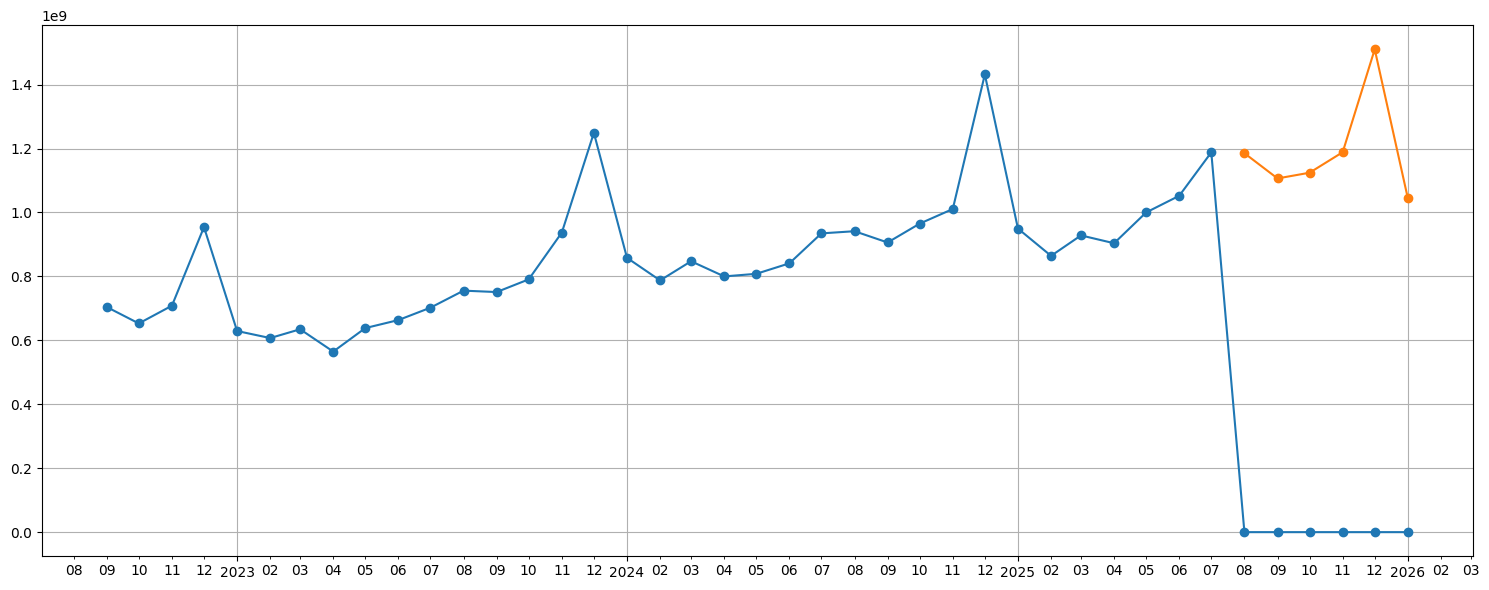

In [40]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the data

# Setting the x-axis to show both year and month
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

ax.plot(
    df.groupby(time_col)[target_col].sum(),
    marker='o', linestyle='-'
)


ax.plot(
    df_forecast_test[(~df_forecast_test['revenue_holtwintersAS'].isna())].groupby(time_col)['revenue_holtwintersAS'].sum(),
    marker='o', linestyle='-'
)

# ax.plot(
#     df_forecast[(~df_forecast['revenue_holtwintersAS'].isna())].groupby(time_col)['revenue_holtwintersAS'].sum(),
#     marker='o', linestyle='-'
# )



# Displaying the grid and the plot
ax.grid(True)
plt.tight_layout()
plt.show()

In [41]:
scalers = {}

def scale_group(sub_df, cols):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(sub_df[cols])
    scalers[sub_df.name] = scaler  # sub_df.name is the group key (e.g., series_id)
    scaled_cols = [f'scaled_{col}' for col in cols]
    sub_df[scaled_cols] = scaled_values
    return sub_df

cols = ['revenue', 'revenue_holtwintersAS'] 
scaled_cols = [f'scaled_{col}' for col in cols]
inversed_cols = [f'scaled_{col}' for col in cols]

df_forecast = df_forecast.groupby(group_cols, group_keys=False).apply(scale_group, cols =cols)

In [76]:
df_forecast

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,qty_days_zero,coef_holidays_mean,coef_holidays_sum,coef_holidays_std,coef_holidays_max,coef_holidays_median,weight_holidays
0,2022-09-01,80001,959082.0,train,9.590820e+05,9.590820e+05,0.197770,0.049970,0.266667,0.166667,0.033333,1.280838,38.425126,0.219253,1.778441,1.315360,1.084432
1,2022-10-01,80001,887611.0,train,8.876110e+05,8.876110e+05,0.183032,0.036388,0.322581,0.161290,0.032258,1.222505,37.897665,0.218348,1.571131,1.233449,1.134074
2,2022-11-01,80001,1095856.0,train,1.095856e+06,1.095856e+06,0.225974,0.075962,0.266667,0.733333,0.100000,1.770242,53.107264,0.503126,2.857359,1.664693,2.432921
3,2022-12-01,80001,1875755.0,train,1.875755e+06,1.875755e+06,0.386795,0.224170,0.290323,0.677419,0.064516,1.921883,59.578383,0.400154,2.795385,1.875982,1.595335
4,2023-01-01,80001,994723.0,train,9.947230e+05,9.947230e+05,0.205120,0.056743,0.290323,0.258065,0.064516,1.241920,38.499518,0.367508,1.632094,1.317183,1.264034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43660,2025-09-01,4675849,1.0,test,2.768911e+05,2.667377e+05,0.000000,0.690296,0.266667,0.166667,0.033333,1.145947,34.378408,0.097760,1.273890,1.155858,1.018547
43661,2025-10-01,4675849,1.0,test,3.106709e+05,2.894641e+05,0.000000,0.771133,0.258065,0.258065,0.096774,1.144497,35.479419,0.104982,1.301705,1.164305,1.134074
43662,2025-11-01,4675849,1.0,test,3.294739e+05,2.479136e+05,0.000000,0.623339,0.333333,0.733333,0.133333,1.439680,43.190390,0.469693,2.620560,1.264701,2.432921
43663,2025-12-01,4675849,1.0,test,3.580010e+05,2.218201e+05,0.000000,0.530525,0.258065,0.806452,0.096774,1.644399,50.976368,0.329785,2.380797,1.498835,1.595335


In [77]:
def inverse_scale_group(sub_df, cols_scaled, cols_inversed):
    scaler = scalers[sub_df.name]
    original_values = scaler.inverse_transform(sub_df[cols_scaled])
    sub_df[cols_inversed] = original_values
    return sub_df

# recovered_df = df_forecast.groupby(group_cols, group_keys = False).apply(
#                                                                     inverse_scale_group, 
#                                                                     cols_scaled = scaled_cols,
#                                                                     cols_inversed = inversed_cols
#                                                                   )

# Holidays calculation

In [46]:
date_str = str(training_cutoff).split(' ')[0]
created_seasonality_date = "".join(date_str.split('-'))
holiday_file_month = training_cutoff

In [74]:
from utils.holidays import get_holiday_date

In [72]:
holiday_file_month = get_holiday_date(training_cutoff)
holiday_file_path=f'gs://rztk-cma/holidays_by_models/revenue/created={holiday_file_month}/holidays_coefficients.csv'
df_holidays, weights_df, features_holidays_df = holidays_df(holiday_file_path)

Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [73]:
df_forecast = df_forecast.merge(features_holidays_df, how='left', on='period')
df_forecast.head(5)

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,qty_days_zero,coef_holidays_mean,coef_holidays_sum,coef_holidays_std,coef_holidays_max,coef_holidays_median,weight_holidays
0,2022-09-01,80001,959082.0,train,959082.0,959082.0,0.197770,0.049970,0.266667,0.166667,0.033333,1.280838,38.425126,0.219253,1.778441,1.315360,1.084432
1,2022-10-01,80001,887611.0,train,887611.0,887611.0,0.183032,0.036388,0.322581,0.161290,0.032258,1.222505,37.897665,0.218348,1.571131,1.233449,1.134074
2,2022-11-01,80001,1095856.0,train,1095856.0,1095856.0,0.225974,0.075962,0.266667,0.733333,0.100000,1.770242,53.107264,0.503126,2.857359,1.664693,2.432921
3,2022-12-01,80001,1875755.0,train,1875755.0,1875755.0,0.386795,0.224170,0.290323,0.677419,0.064516,1.921883,59.578383,0.400154,2.795385,1.875982,1.595335
4,2023-01-01,80001,994723.0,train,994723.0,994723.0,0.205120,0.056743,0.290323,0.258065,0.064516,1.241920,38.499518,0.367508,1.632094,1.317183,1.264034


## Category sale start

In [78]:
category_start_sale = df_forecast[df_forecast.revenue>0].groupby(['category_id'])['period'].min().reset_index()
category_start_sale = category_start_sale.rename(columns={'period':'sales_start'})
category_start_sale['sales_start_plus_year'] = category_start_sale['sales_start'] + pd.DateOffset(years=1)
category_start_sale['sales_start_plus_two_years'] = category_start_sale['sales_start'] + pd.DateOffset(years=2)
category_start_sale.head(2)

,category_id,sales_start,sales_start_plus_year,sales_start_plus_two_years
0,80001,2022-09-01,2023-09-01,2024-09-01
1,80002,2022-09-01,2023-09-01,2024-09-01


In [79]:
df_forecast['month'] = df_forecast[time_col].dt.month

## Adding seasonality features

In [80]:
df = add_revenue_ratio_seasonality(df_forecast,
                                   target_cols = [target_col], 
                                   training_cutoff = pd.to_datetime(training_cutoff),
                                   time_col = time_col,
                                   group_columns = ['category_id'],
                                  )

In [81]:
lower_bound_data = df.period.min()


df = add_mnth_to_mnth_lagged(df, 
                             target_cols = [target_col], 
                             training_cutoff = pd.to_datetime(training_cutoff),
                             time_col = time_col,
                             lower_bound = lower_bound_data,
                             group_columns = ['category_id',],
                            )

In [82]:
df = add_yty_lagged(df,
                    category_start_sale=category_start_sale,
                    target_cols = [target_col], 
                    training_cutoff = pd.to_datetime(training_cutoff),
                    time_col = time_col,
                    lower_bound = lower_bound_data,
                    group_columns = ['category_id'],
                    )

In [83]:
df = add_seasonality_with_percentile(df,
                     category_start_sale=category_start_sale,
                     target_cols = [target_col], 
                     training_cutoff = pd.to_datetime(training_cutoff),
                     time_col = time_col,
                     forecast_horizon = forecast_horizon,
                     lower_bound = pd.to_datetime('2019-01-01', format='%Y-%m-%d'),
                     percentile=0.95
                    )

In [84]:
month = df['period'].dt.month
quarter = df['period'].dt.quarter

df['month'] = month
df["month_sin"] = np.sin(2 * np.pi * month  * 1./12)
df["month_cos"] = np.cos(2 * np.pi * month * 1./12)
df["quarter_sin"] = np.sin(2 * np.pi * quarter / 4)
df["quarter_cos"] = np.cos(2 * np.pi * quarter / 4)

In [85]:
df[df.category_id==80001].head(1)

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,...,sales_start_plus_two_years,aggregated_seasonality_1y,aggregated_seasonality_2y,number_of_years_since_sales_start,seasonality,seasonality_shifted_forward_12,month_sin,month_cos,quarter_sin,quarter_cos
0,2022-09-01,80001,959082.0,train,959082.0,959082.0,0.19777,0.04997,0.266667,0.166667,...,2024-09-01,1.216923,1.060146,0.0,1.0,NaN,-1.0,-1.836970e-16,-1.0,-1.836970e-16


In [86]:
df.columns

Index(['period', 'category_id', 'revenue', 'subset_type',
       'revenue_holtwintersMS', 'revenue_holtwintersAS', 'scaled_revenue',
       'scaled_revenue_holtwintersAS', 'weekday_count_6_7',
       'qty_days_non_negative', 'qty_days_zero', 'coef_holidays_mean',
       'coef_holidays_sum', 'coef_holidays_std', 'coef_holidays_max',
       'coef_holidays_median', 'weight_holidays', 'month',
       'revenue_ratio_seasonality', 'revenue_mnth_to_mnth_lagged',
       'yty_lagged', 'historical_seasonality', 'median_col', 'percentile_col',
       'sales_start', 'sales_start_plus_year', 'sales_start_plus_two_years',
       'aggregated_seasonality_1y', 'aggregated_seasonality_2y',
       'number_of_years_since_sales_start', 'seasonality',
       'seasonality_shifted_forward_12', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos'],
      dtype='object')

In [87]:
target_col = 'scaled_revenue'

train_cols = [
    'scaled_revenue_holtwintersAS',
    'weekday_count_6_7',
    'qty_days_non_negative',
    'qty_days_zero',
    'coef_holidays_mean',
    'coef_holidays_sum',
    'coef_holidays_std', 
    'coef_holidays_max',
    'coef_holidays_median', 
    'weight_holidays',
    'revenue_ratio_seasonality', 
    'revenue_mnth_to_mnth_lagged',
    'yty_lagged',
    'seasonality',
    'month',
    'month_sin', 
    'month_cos',
    'quarter_sin', 
    'quarter_cos'
]

In [88]:
lower_bound_cutoff = '2023-08-01'
df = df[(df.period > lower_bound_cutoff)]

In [ ]:
df[]

In [159]:
# df.to_csv('df.csv',index=False)

In [92]:
n_folds = 4
fold_len = 3

validation_end = [pd.to_datetime(training_cutoff) - pd.DateOffset(months=val_num) for val_num in range(n_folds)]
validation_start = [val_end - pd.DateOffset(months=fold_len-1) for val_end in validation_end]
# print(df[(df.category_id==80001)][['period','subset_type', 'revenue']])    

In [162]:
# validation_start

[Timestamp('2025-05-01 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-03-01 00:00:00'),
 Timestamp('2025-02-01 00:00:00')]

In [161]:
# validation_end,

[Timestamp('2025-07-01 00:00:00'),
 Timestamp('2025-06-01 00:00:00'),
 Timestamp('2025-05-01 00:00:00'),
 Timestamp('2025-04-01 00:00:00')]

In [163]:
df.loc[(df[time_col] < validation_start[0]), 'subset_type'] = 'test'
df.loc[(df[time_col] >= validation_start[0]) & (df[time_col] <= validation_end[0]), 'subset_type'] = 'validation'
df.loc[df[time_col] > training_cutoff, 'subset_type'] = 'test'

In [89]:
df[(df.category_id==80001) ][['period','subset_type', 'revenue']]

,period,subset_type,revenue
12,2023-09-01,train,881816.0
13,2023-10-01,train,884227.0
14,2023-11-01,train,886517.0
15,2023-12-01,train,2168143.0
16,2024-01-01,train,1024537.0
17,2024-02-01,train,1062629.0
18,2024-03-01,train,997225.0
19,2024-04-01,train,704860.0
20,2024-05-01,train,831846.0
21,2024-06-01,train,1267410.0


In [93]:
import scipy
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm


# Use train/val/test split or k-folds cross validation
tune_with_kfolds = True

# Define the parameter distributions for hyperparameter tuning
# Using this guide: https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# Parameter documentation: https://xgboost.readthedocs.io/en/stable/parameter.html
param_distributions = {
    "learning_rate": scipy.stats.uniform(loc=0.003, scale=0.19),  # Default is 0.3. Ranges from loc to loc+scale.
    "subsample": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1
    "colsample_bytree": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1
    "min_child_weight": [1, 3, 5, 7],  # Default is 1
    "max_depth": np.append(0, np.arange(3, 16)),  # Default is 6
    "alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],  # Default is 0. AKA reg_alpha.
    "lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]  # Default is 0. AKA reg_lambda.
}

def sample_from_param_distributions(param_distributions: dict) -> dict:
    """
    Sample a value from each parameter distribution defined in param_distributions.

    Parameters:
    - param_distributions (dict): Dictionary where keys are parameter names and values are either:
        - scipy.stats distribution objects for continuous distributions.
        - Lists or numpy arrays for discrete choices.

    Returns:
    - sampled_values (dict): Dictionary containing sampled values corresponding to each parameter.
    """
    sampled_values = {}
    for param, distribution in param_distributions.items():
        if isinstance(distribution, scipy.stats._distn_infrastructure.rv_frozen):
            sampled_values[param] = distribution.rvs()
        elif isinstance(distribution, list) or isinstance(distribution, np.ndarray):
            sampled_values[param] = np.random.choice(distribution)
        else:
            raise ValueError(f"Unsupported distribution type for parameter '{param}'")

    return sampled_values

In [94]:
num_iterations = 200
optimal_params = {}
best_score = -np.inf

tune_with_kfolds = True

for iteration in tqdm(range(num_iterations)):
    # Sample values from the distributions
    sampled_params = sample_from_param_distributions(param_distributions)
    # Train the model, get the performance on the validation set
    model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=20,
                             n_jobs=-1, random_state=46, **sampled_params)
    neg_mean_squared_error_lst = []
    for val_start, val_end in zip(validation_start, validation_end):
        
        df.loc[(df[time_col] < val_start), 'subset_type'] = 'train'
        df.loc[(df[time_col] >= val_start) & (df[time_col] <= val_end), 'subset_type'] = 'validation'
        df.loc[(df[time_col] > val_end) & (df[time_col] <= training_cutoff), 'subset_type'] = 'train'
        df.loc[df[time_col] > training_cutoff, 'subset_type'] = 'test'

        X_train = df[(df.subset_type=='train')][train_cols]
        y_train = df[(df.subset_type=='train')][target_col]

        X_val = df[(df.subset_type=='validation')][train_cols]
        y_val = df[(df.subset_type=='validation')][target_col]
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        predictions = model.predict(X_val)
        neg_mean_squared_error_lst.append(-mean_squared_error(y_true=y_val, y_pred=predictions))
        neg_mean_squared_error = np.mean(neg_mean_squared_error_lst)
        
    if neg_mean_squared_error > best_score:
        best_score = neg_mean_squared_error
        optimal_params = sampled_params
        # Need to re-train w/ early stopping to get optimal number of estimators if tuned with k-folds
    

100%|██████████| 200/200 [08:12<00:00,  2.46s/it]


In [99]:
val_start = validation_start[0]
val_end = validation_end[0]
        
df.loc[(df[time_col] < val_start), 'subset_type'] = 'train'
df.loc[(df[time_col] >= val_start) & (df[time_col] <= val_end), 'subset_type'] = 'validation'
df.loc[(df[time_col] > val_end) & (df[time_col] <= training_cutoff), 'subset_type'] = 'train'
df.loc[df[time_col] > training_cutoff, 'subset_type'] = 'test'

X_train = df[(df.subset_type=='train')][train_cols]
y_train = df[(df.subset_type=='train')][target_col]

X_val = df[(df.subset_type=='validation')][train_cols]
y_val = df[(df.subset_type=='validation')][target_col]

tuned_model = xgb.XGBRegressor(**optimal_params, n_jobs=-1, random_state=46,
                                   n_estimators=10000, early_stopping_rounds=20)

tuned_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
optimal_params["n_estimators"] = tuned_model.best_iteration

optimal_params

In [101]:
X_test = df[(df.subset_type=='test')][train_cols]
y_test = df[(df.subset_type=='test')][target_col]

y_forecast = tuned_model.predict(X_test)
df_forecast_xg = df[(df.subset_type=='test')]
df_forecast_xg['revenue_predicted_scaled'] = y_forecast

In [102]:
df_forecast_xg[df_forecast_xg.category_id==80001]

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,...,aggregated_seasonality_1y,aggregated_seasonality_2y,number_of_years_since_sales_start,seasonality,seasonality_shifted_forward_12,month_sin,month_cos,quarter_sin,quarter_cos,revenue_predicted_scaled
35,2025-08-01,80001,1.0,test,4.119890e+06,3.823642e+06,0.0,0.594336,0.322581,0.354839,...,1.171901,1.085950,2.0,1.085950,1.171901,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,0.679933
36,2025-09-01,80001,1.0,test,4.342413e+06,3.878245e+06,0.0,0.604712,0.266667,0.166667,...,1.216923,1.060146,2.0,1.060146,1.216923,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.703711
37,2025-10-01,80001,1.0,test,4.071034e+06,3.777788e+06,0.0,0.585622,0.258065,0.258065,...,1.035611,0.973732,2.0,0.973732,1.035611,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,0.648163
38,2025-11-01,80001,1.0,test,5.417507e+06,4.310250e+06,0.0,0.686808,0.333333,0.733333,...,1.808281,1.361381,2.0,1.361381,1.808281,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.789842
39,2025-12-01,80001,1.0,test,9.981501e+06,5.958328e+06,0.0,1.000000,0.258065,0.806452,...,2.247136,2.247136,2.0,2.247136,2.247136,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,0.998256
40,2026-01-01,80001,1.0,test,4.215002e+06,3.320444e+06,0.0,0.498711,0.290323,0.096774,...,1.044456,1.046910,2.0,1.046910,1.044456,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,0.356204


In [103]:
scaled_cols = ['revenue_predicted_scaled', 'scaled_revenue_holtwintersAS']
inversed_cols = ['revenue_predicted', 'inversed_revenue_holtwintersAS']

In [104]:
def inverse_scale_group(sub_df, cols_scaled, cols_inversed):
    scaler = scalers[sub_df.name]
    original_values = scaler.inverse_transform(sub_df[cols_scaled])
    sub_df[cols_inversed] = original_values
    return sub_df

df_forecast_xg = df_forecast_xg.groupby(group_cols, group_keys = False).apply(
                                                                    inverse_scale_group, 
                                                                    cols_scaled = scaled_cols,
                                                                    cols_inversed = inversed_cols
                                                                  )

In [105]:
df_forecast_xg

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,...,number_of_years_since_sales_start,seasonality,seasonality_shifted_forward_12,month_sin,month_cos,quarter_sin,quarter_cos,revenue_predicted_scaled,revenue_predicted,inversed_revenue_holtwintersAS
35,2025-08-01,80001,1.0,test,4.119890e+06,3.823642e+06,0.0,0.594336,0.322581,0.354839,...,2.0,1.085950,1.171901,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,0.679933,3.297320e+06,3.823642e+06
36,2025-09-01,80001,1.0,test,4.342413e+06,3.878245e+06,0.0,0.604712,0.266667,0.166667,...,2.0,1.060146,1.216923,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.703711,3.412630e+06,3.878245e+06
37,2025-10-01,80001,1.0,test,4.071034e+06,3.777788e+06,0.0,0.585622,0.258065,0.258065,...,2.0,0.973732,1.035611,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,0.648163,3.143252e+06,3.777788e+06
38,2025-11-01,80001,1.0,test,5.417507e+06,4.310250e+06,0.0,0.686808,0.333333,0.733333,...,2.0,1.361381,1.808281,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.789842,3.830317e+06,4.310250e+06
39,2025-12-01,80001,1.0,test,9.981501e+06,5.958328e+06,0.0,1.000000,0.258065,0.806452,...,2.0,2.247136,2.247136,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,0.998256,4.841019e+06,5.958328e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43660,2025-09-01,4675849,1.0,test,2.768911e+05,2.667377e+05,0.0,0.690296,0.266667,0.166667,...,2.0,0.935954,1.141699,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.461837,1.709751e+05,2.667377e+05
43661,2025-10-01,4675849,1.0,test,3.106709e+05,2.894641e+05,0.0,0.771133,0.258065,0.258065,...,2.0,1.087029,1.154270,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,0.765563,2.834155e+05,2.894641e+05
43662,2025-11-01,4675849,1.0,test,3.294739e+05,2.479136e+05,0.0,0.623339,0.333333,0.733333,...,2.0,1.357564,1.093766,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.793596,2.937936e+05,2.479136e+05
43663,2025-12-01,4675849,1.0,test,3.580010e+05,2.218201e+05,0.0,0.530525,0.258065,0.806452,...,2.0,1.432064,1.474838,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,0.804373,2.977830e+05,2.218201e+05


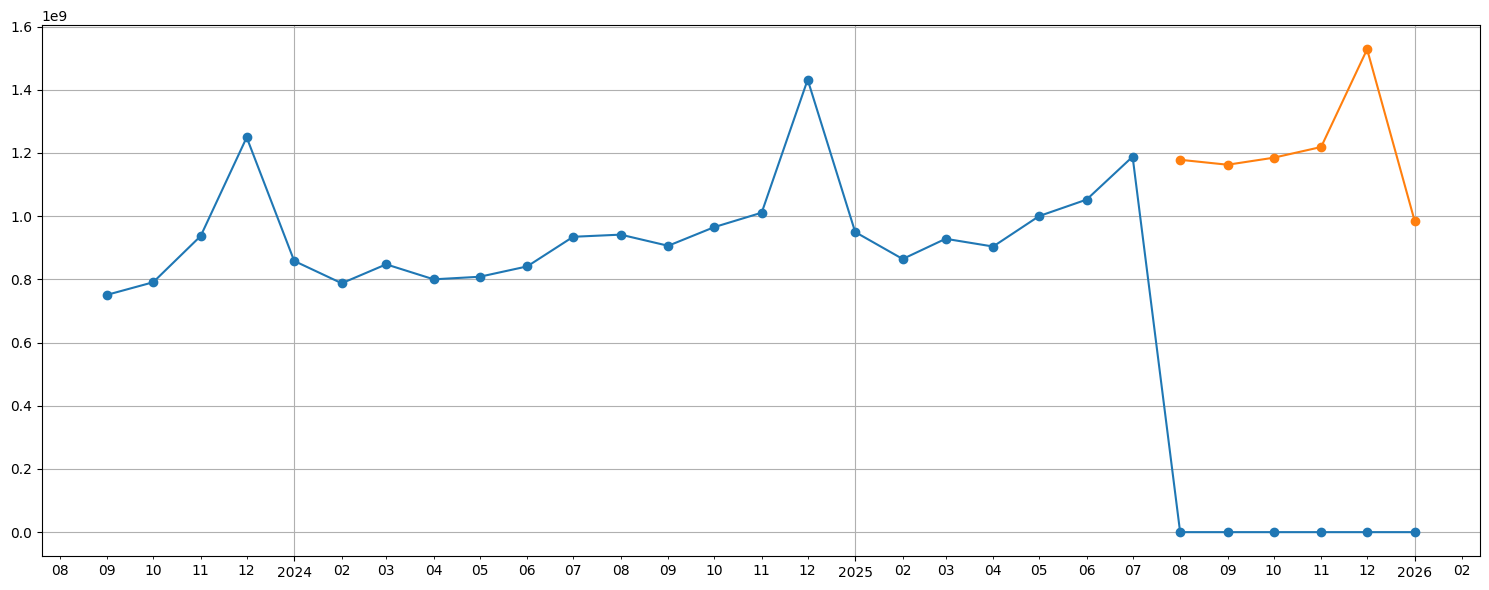

In [106]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the data
target_col = 'revenue'

# Setting the x-axis to show both year and month
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

ax.plot(
    df.groupby(time_col)[target_col].sum(),
    marker='o', linestyle='-'
)


ax.plot(
    df_forecast_xg[(~df_forecast_xg['revenue_predicted'].isna())].groupby(time_col)['revenue_predicted'].sum(),
    marker='o', linestyle='-'
)

# ax.plot(
#     df_forecast[(~df_forecast['revenue_holtwintersAS'].isna())].groupby(time_col)['revenue_holtwintersAS'].sum(),
#     marker='o', linestyle='-'
# )



# Displaying the grid and the plot
ax.grid(True)
plt.tight_layout()
plt.show()

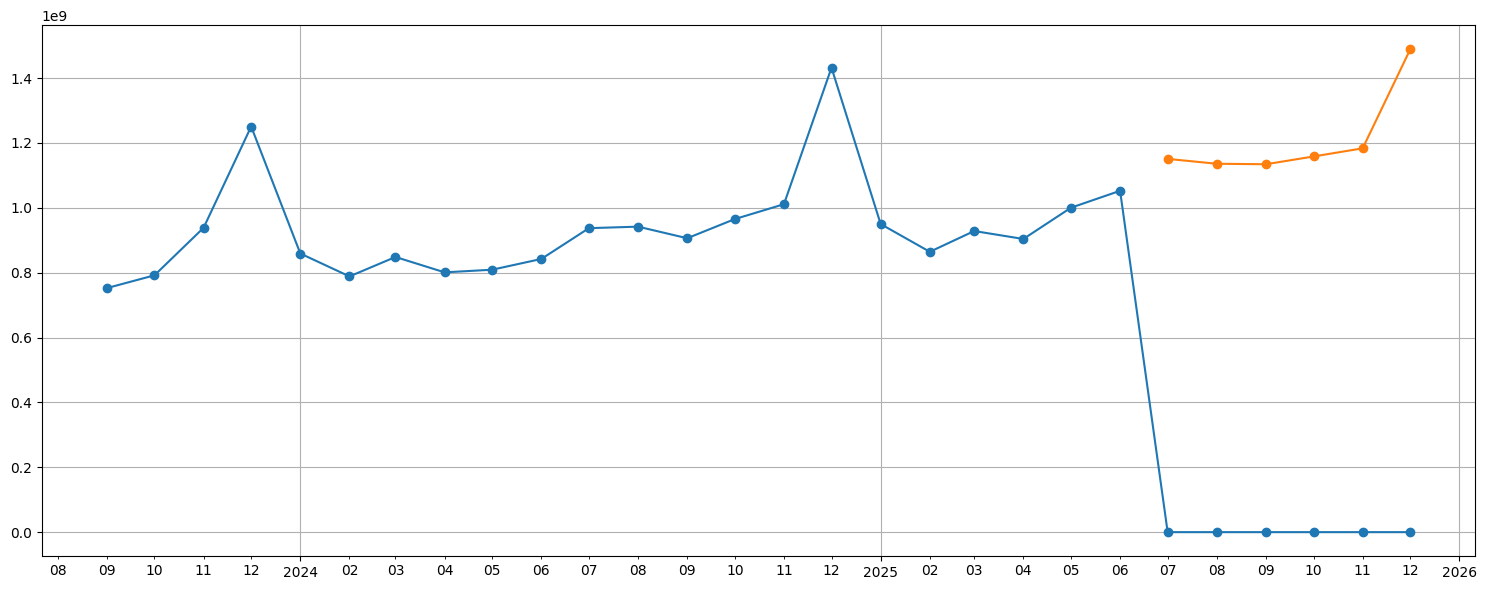

In [116]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the data
target_col = 'revenue'

# Setting the x-axis to show both year and month
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

ax.plot(
    df.groupby(time_col)[target_col].sum(),
    marker='o', linestyle='-'
)


ax.plot(
    df_forecast_xg[(~df_forecast_xg['revenue_predicted'].isna())].groupby(time_col)['revenue_predicted'].sum(),
    marker='o', linestyle='-'
)

# ax.plot(
#     df_forecast[(~df_forecast['revenue_holtwintersAS'].isna())].groupby(time_col)['revenue_holtwintersAS'].sum(),
#     marker='o', linestyle='-'
# )



# Displaying the grid and the plot
ax.grid(True)
plt.tight_layout()
plt.show()

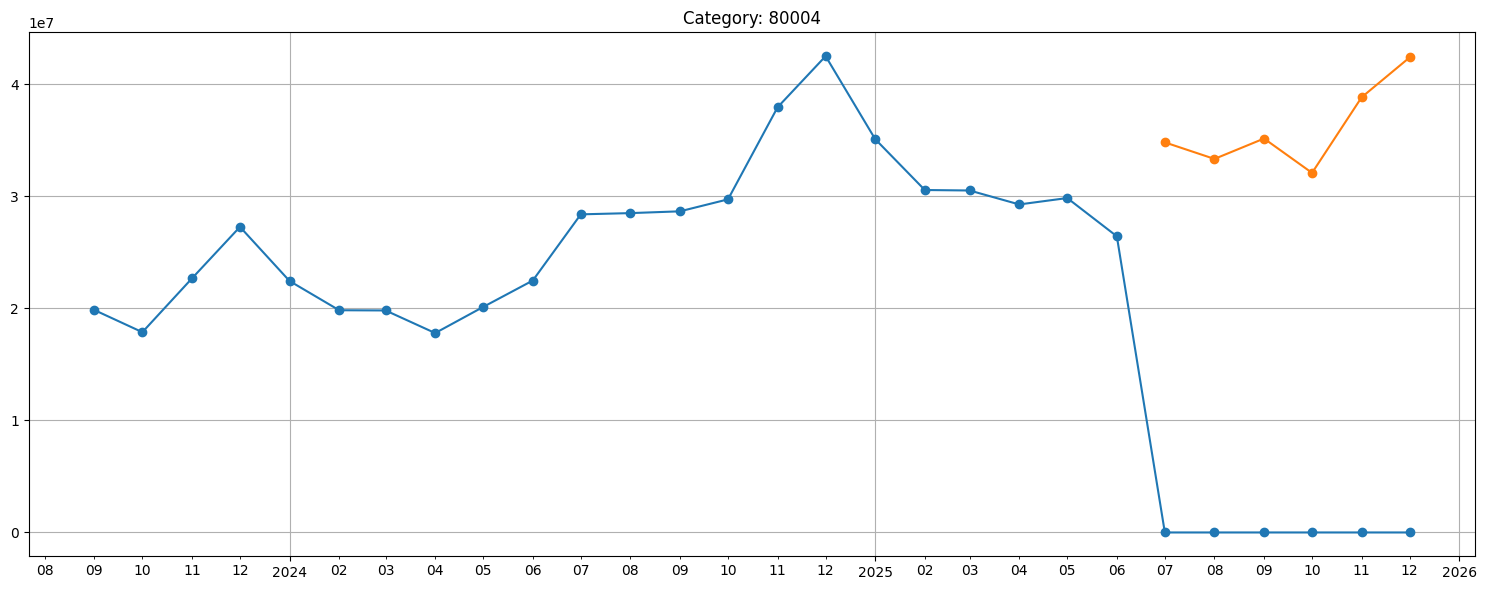

In [117]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the data
target_col = 'revenue'
category_id = 80004
# Setting the x-axis to show both year and month
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

ax.plot(
    df[(df['category_id']==category_id)].groupby(time_col)[target_col].sum(),
    marker='o', linestyle='-'
)


ax.plot(
    df_forecast_xg[(~df_forecast_xg['revenue_predicted'].isna()) & (df_forecast_xg['category_id']==category_id)].groupby(time_col)['revenue_predicted'].sum(),
    marker='o', linestyle='-'
)

# ax.plot(
#     df_forecast[(~df_forecast['revenue_holtwintersAS'].isna())].groupby(time_col)['revenue_holtwintersAS'].sum(),
#     marker='o', linestyle='-'
# )



# Displaying the grid and the plot
ax.grid(True)
plt.title(f"Category: {category_id}")
plt.tight_layout()
plt.show()

In [371]:
# import matplotlib.dates as mdates
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(15, 6))

# # Plotting the data
# target_col = 'seasonality'
# # Setting the x-axis to show both year and month
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

# plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

# ax.plot(
#     df[df.category_id==80001].groupby(time_col)[target_col].mean(),
#     marker='o', linestyle='-'
# )



# # Displaying the grid and the plot
# ax.grid(True)
# plt.tight_layout()
# plt.show()

In [372]:
# import matplotlib.dates as mdates
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(15, 6))

# # Plotting the data
# target_col = 'revenue'
# # Setting the x-axis to show both year and month
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

# plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, )

# ax.plot(
#     df[df.category_id==80001].groupby(time_col)[target_col].sum(),
#     marker='o', linestyle='-'
# )



# # Displaying the grid and the plot
# ax.grid(True)
# plt.tight_layout()
# plt.show()

In [33]:
# metrics_df = recovered_df.merge(df, how='left', on=['period', 'category_id'])
# metrics_df = metrics_df.rename(columns={'inversed_revenue_pred': 'revenue_pred'})
# metrics_df = metrics_df[['period','category_id', 'revenue', 'revenue_pred']]
# metrics_df['abs_diff'] = abs(metrics_df['revenue_pred'] - metrics_df['revenue'])
# metrics_df['percentage_error'] = metrics_df['abs_diff'] / metrics_df['revenue']

# metrics_df_agg = metrics_df.groupby(['period'])[['revenue', 'abs_diff']].sum().reset_index()

In [34]:
# metrics_df_agg['wape'] = np.round(metrics_df_agg['abs_diff'] / metrics_df_agg['revenue'], 2)
# metrics_df_agg[['period', 'wape']]

# Save results

In [175]:
import uuid
import time

experiment_run_name = "forecasting-revenue-market"
experiment_run = f"{experiment_run_name}-{uuid.uuid4().hex[:8]}"
experiment_run

'forecasting-revenue-market-deea7c05'

In [176]:
df_forecast_xg

,period,category_id,revenue,subset_type,revenue_holtwintersMS,revenue_holtwintersAS,scaled_revenue,scaled_revenue_holtwintersAS,weekday_count_6_7,qty_days_non_negative,...,number_of_years_since_sales_start,seasonality,seasonality_shifted_forward_12,month_sin,month_cos,quarter_sin,quarter_cos,revenue_predicted_scaled,revenue_predicted,inversed_revenue_holtwintersAS
35,2025-08-01,80001,1.0,test,4.119890e+06,3.823642e+06,0.0,0.594336,0.322581,0.354839,...,2.0,1.085950,1.171901,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,0.663629,3.218253e+06,3.823642e+06
36,2025-09-01,80001,1.0,test,4.342413e+06,3.878245e+06,0.0,0.604712,0.266667,0.166667,...,2.0,1.060146,1.216923,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.728377,3.532247e+06,3.878245e+06
37,2025-10-01,80001,1.0,test,4.071034e+06,3.777788e+06,0.0,0.585622,0.258065,0.258065,...,2.0,0.973732,1.035611,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,0.655943,3.180981e+06,3.777788e+06
38,2025-11-01,80001,1.0,test,5.417507e+06,4.310250e+06,0.0,0.686808,0.333333,0.733333,...,2.0,1.361381,1.808281,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.790857,3.835242e+06,4.310250e+06
39,2025-12-01,80001,1.0,test,9.981501e+06,5.958328e+06,0.0,1.000000,0.258065,0.806452,...,2.0,2.247136,2.247136,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,1.035358,5.020941e+06,5.958328e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43660,2025-09-01,4675849,1.0,test,2.768911e+05,2.667377e+05,0.0,0.690296,0.266667,0.166667,...,2.0,0.935954,1.141699,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.459368,1.700609e+05,2.667377e+05
43661,2025-10-01,4675849,1.0,test,3.106709e+05,2.894641e+05,0.0,0.771133,0.258065,0.258065,...,2.0,1.087029,1.154270,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,0.796883,2.950102e+05,2.894641e+05
43662,2025-11-01,4675849,1.0,test,3.294739e+05,2.479136e+05,0.0,0.623339,0.333333,0.733333,...,2.0,1.357564,1.093766,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.807116,2.987987e+05,2.479136e+05
43663,2025-12-01,4675849,1.0,test,3.580010e+05,2.218201e+05,0.0,0.530525,0.258065,0.806452,...,2.0,1.432064,1.474838,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,0.837243,3.099516e+05,2.218201e+05


In [177]:
out_df = df_forecast_xg[['period', 'category_id', 'revenue_predicted']].copy()
#pd.read_csv('market.csv')
out_df = out_df.rename(columns={'period':'month',
                                'revenue_predicted': 'revenue'
                               })
out_df = out_df[['month', 'category_id', 'revenue']]

out_df['month'] = out_df['month'].astype('datetime64[ns]')
out_df = out_df.fillna(0)
out_df['experiment_run']  = experiment_run
out_df.head()

,month,category_id,revenue,experiment_run
35,2025-08-01,80001,3.218253e+06,forecasting-revenue-market-deea7c05
36,2025-09-01,80001,3.532247e+06,forecasting-revenue-market-deea7c05
37,2025-10-01,80001,3.180981e+06,forecasting-revenue-market-deea7c05
38,2025-11-01,80001,3.835242e+06,forecasting-revenue-market-deea7c05
39,2025-12-01,80001,5.020941e+06,forecasting-revenue-market-deea7c05


In [122]:
# out_df

In [95]:
x = ['s']
['r', *x]

['r', 's']

In [178]:
def save_batch_to_kh(df, client, table_name="dev_predictions_month_category", schema_name="forecasting_revenue_market", add_version=True):
    if client is None:
        raise ValueError("Client cannot be None")
    if add_version and "ver" not in df.columns:
        df["ver"] = pd.to_datetime("now", utc=True)
    FULL_TABLE_NAME = f'{schema_name}.{table_name}'

    if df.empty:
        print("Warning: DataFrame is empty. No data inserted.")
        return

    client.insert_df(
        table=table_name,
        df=df,
        database=schema_name
    )
    time.sleep(1)

In [179]:
save_batch_to_kh(out_df,
                 client=client_cma, 
                 table_name="dev_predictions_month_category", 
                 schema_name="forecasting_revenue_market", 
                 add_version=True)

In [2]:
import json    
from datetime import datetime, timedelta
import pickle 
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
x = (datetime.now() - relativedelta(months=+1)).replace(day=1).strftime('%Y-%m-%d')